# GRU  Training Set

In [1]:
import os 
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import DatasetFolder
from torch.nn.utils.rnn import pack_padded_sequence as PACK
sns.set()
import gc



In [2]:
plt.style.use("seaborn")
sns.set(font_scale=1)

seed = 777
random.seed(seed)

## Preprocess Data

In [3]:

holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
                

In [8]:
root = 'ashrae-energy-prediction/dataloader_train_meteronly/csv/class_0/'

In [9]:
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(root)): 
    
    if file[-4:] != ".csv":
        continue

        
    df = pd.read_csv(root + file, index_col=[0], parse_dates=['timestamp'])
        # Processing the time data into suitable input formats
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_year"] = df["timestamp"].dt.dayofyear
    df["week"] = df["timestamp"].dt.week
    df = df.sort_values("timestamp").drop("timestamp",axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 1
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])
    
 

    del df, sc, label_sc, data;
    gc.collect()
    

KeyboardInterrupt: 

In [6]:
df = pd.DataFrame.from_dict(label_scalers, orient="index")
df.to_csv("label_scalers.csv")

In [7]:
#df = pd.read_csv("scalers.csv", index_col=0)
#d = df.to_dict("split")
#d = dict(zip(d["index"], d["data"]))

## Build DataLoader

In [8]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [9]:
del train_x, train_y, train_data
gc.collect()

22

# Prepare LSTM

In [10]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [12]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y, y_pred):
    np.sqrt(mean_squared_log_error( y, y_pred ))

In [13]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=40, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRU(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        #outputs.append(out.cpu().detach().numpy())
        #targets.append(inverse_transform(labs.numpy()))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    RMSLE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
        #RMSLE += rmsle(targets[i], outputs[i])
    #print("RMSLE: {}".format(RMSLE))
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

## Train model

In [14]:
%%time
lr = 0.0001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 200/17462....... Average Loss for Epoch: 0.05396003824658692
Epoch 1......Step: 400/17462....... Average Loss for Epoch: 0.030418737991712987
Epoch 1......Step: 600/17462....... Average Loss for Epoch: 0.021709913669231657
Epoch 1......Step: 800/17462....... Average Loss for Epoch: 0.017312373367894908
Epoch 1......Step: 1000/17462....... Average Loss for Epoch: 0.014651778331492097
Epoch 1......Step: 1200/17462....... Average Loss for Epoch: 0.012867798932517568
Epoch 1......Step: 1400/17462....... Average Loss for Epoch: 0.01159554548212327
Epoch 1......Step: 1600/17462....... Average Loss for Epoch: 0.0106331258204591
Epoch 1......Step: 1800/17462....... Average Loss for Epoch: 0.009879242678483327
Epoch 1......Step: 2000/17462....... Average Loss for Epoch: 0.00927627084928099
Epoch 1......Step: 2200/17462....... Average Loss for Epoch: 0.008792394872924143
Epoch 1......Step: 2400/17462....... Average Loss for Epoch: 0.0083861457686

In [15]:
del train_loader;
gc.collect()

0

In [16]:
torch.save(gru_model, 'gru_model_2.pt')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
#gru_model = torch.load('gru_model.pt')

In [18]:
gru_outputs, targets, gru_smape = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 1.9620410000006814
sMAPE: 8.792404866438918%


## Visualize Results

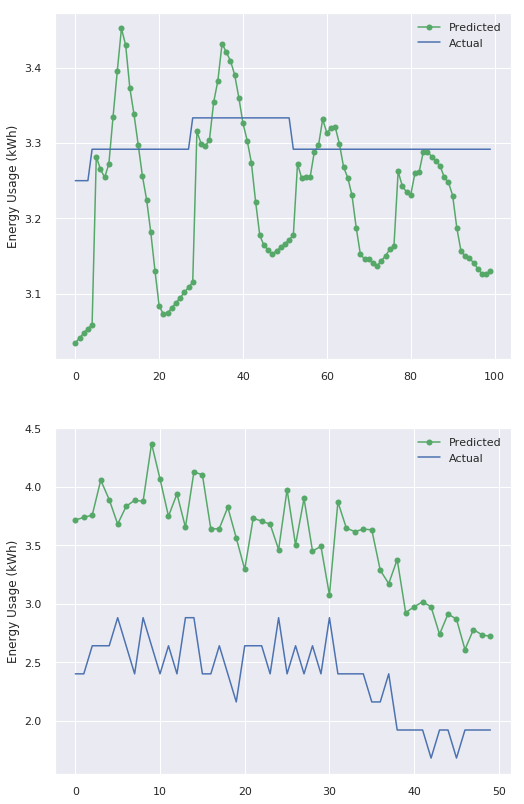

In [19]:
fig = plt.figure(figsize=(18,14))

plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Usage (kWh)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[150][-50:], "-o", color="g", label="Predicted")
plt.plot(targets[150][-50:], color="b", label="Actual")
plt.ylabel('Energy Usage (kWh)')
plt.legend()


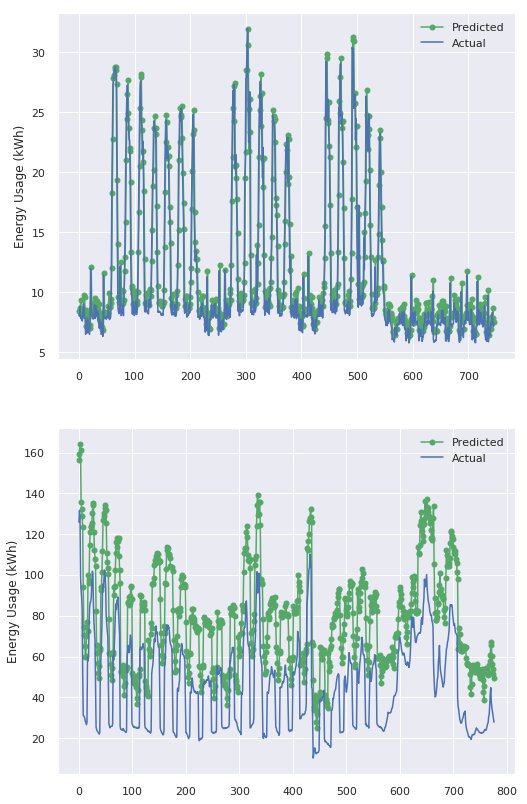

In [20]:
fig = plt.figure(figsize=(18,14))
plt.subplot(2,2,1)
plt.plot(gru_outputs[4][:800], "-o", color="g", label="Predicted")
plt.plot(targets[4][:800], color="b", label="Actual")
plt.ylabel('Energy Usage (kWh)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[1000][100:], "-o", color="g", label="Predicted")
plt.plot(targets[1000][100:], color="b", label="Actual")
plt.ylabel('Energy Usage (kWh)')
plt.legend()